## 1. Import Library 

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense,Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics  import accuracy_score,f1_score,precision_score,recall_score
from keras.utils import to_categorical
import numpy as np
from pyvi import ViTokenizer
import regex as re
import string
np.set_printoptions(threshold=np.inf)

## 2. Data Proprocesing

#### 2.1. Read the file and divide it into sentences

In [2]:
def ReadTXT(file_path):
    with open(file_path, 'r',encoding='utf-8') as file:
        text = file.read()
    sentences = [sentence.strip() for sentence in re.split(r'(?<=[.!?])\s+', text) if sentence.strip()]
    return sentences 

> Execute Function

In [3]:
text_data = ReadTXT("../data/train.txt")

In [4]:
text_data[0:2]

['Trường Đại học Sư phạm Kỹ thuật TP HCM với 53 năm xây dựng và phát triển đã đào tạo cho đất nước hơn 47.500 kỹ sư, giáo viên dạy nghề; 1.300 thạc sỹ; đào tạo và bồi dưỡng nguồn nhân lực chất lượng cao cho hệ thống giáo dục nghề nghiệp cũng như cung cấp đội ngũ kỹ sư cho cả nước.',
 'Trong vài thập kỷ qua, trường nổi lên như một địa chỉ đáng tin cậy của người học, SV tốt nghiệp với chất lượng đào tạo vượt trội, với tỷ lệ có việc làm của SV ra trường thuộc loại cao nhất Việt Nam nhờ thương hiệu nhà trường được các doanh nghiệp trong và ngoài nước ưa chuộng.']

### 2.2.Handle extra whitespace,line breaks, punctuation

In [5]:
def clear(sentence):
  # Create a translation table
  translator = str.maketrans('', '', string.punctuation)
  # Remove punctuation
  new_string = sentence.translate(translator)
  # Remove redudant space and break sign
  new_string = re.sub('[\n ]+', ' ', new_string)
  return new_string

> Execute Function

In [6]:
df_train=[]
for line in text_data:
    sentence=clear(line.lower())
    df_train.append(sentence)
df_train[0:2]

['trường đại học sư phạm kỹ thuật tp hcm với 53 năm xây dựng và phát triển đã đào tạo cho đất nước hơn 47500 kỹ sư giáo viên dạy nghề 1300 thạc sỹ đào tạo và bồi dưỡng nguồn nhân lực chất lượng cao cho hệ thống giáo dục nghề nghiệp cũng như cung cấp đội ngũ kỹ sư cho cả nước',
 'trong vài thập kỷ qua trường nổi lên như một địa chỉ đáng tin cậy của người học sv tốt nghiệp với chất lượng đào tạo vượt trội với tỷ lệ có việc làm của sv ra trường thuộc loại cao nhất việt nam nhờ thương hiệu nhà trường được các doanh nghiệp trong và ngoài nước ưa chuộng']

### 2.3 Compound words with meaning

In [7]:
df_train_compound=[]
for line in df_train:
    sentence = ViTokenizer.tokenize(line)
    df_train_compound.append(sentence)

In [8]:
df_train_compound[0:10]

['trường đại_học sư_phạm kỹ_thuật tp hcm với 53 năm xây_dựng và phát_triển đã đào_tạo cho đất_nước hơn 47500 kỹ_sư giáo_viên dạy nghề 1300 thạc sỹ đào_tạo và bồi_dưỡng nguồn nhân_lực chất_lượng cao cho hệ_thống giáo_dục nghề_nghiệp cũng như cung_cấp đội_ngũ kỹ_sư cho cả nước',
 'trong vài thập_kỷ qua trường nổi lên như một địa_chỉ đáng tin_cậy của người học sv tốt_nghiệp với chất_lượng đào_tạo vượt_trội với tỷ_lệ có việc_làm của sv ra trường thuộc loại cao nhất việt nam nhờ thương_hiệu nhà_trường được các doanh_nghiệp trong và ngoài nước ưa_chuộng',
 'để có được một thương_hiệu nổi_tiếng ngày_nay phong_cách làm_việc kiểu đức đã thấm sâu vào tâm_trí và tiềm_thức của hàng chục thế_hệ gv và sinh_viên khởi_nguồn từ sự_kiện cách đây đúng 50 năm khi chính_phủ chlb đức tài_trợ cho dự_án và đặt viên đá đầu_tiên để xây_dựng ngội trường mang tên th kỹ_thuật việt đức tọa_lạc trên khuôn_viên khoa cơ_khí chế_tạo_máy hiện_nay',
 'tiền_thân của trường trung_học kỹ_thuật việt đức là ban chuyên_nghiệp 

#### 2.4. Create Corpus

In [9]:
def CreateCorpus(Vi):
    tokenizer = Tokenizer(oov_token='<oov>', filters='!“"”#$%&()*+,-./:;<=>?@[\]^`{|}~…')
    tokenizer.fit_on_texts(Vi)
    return tokenizer

>Execute function

In [10]:
df_train_corpus=CreateCorpus(df_train_compound)
print(f"Total Word: {len(df_train_corpus.word_index)+1}")
print(df_train_corpus.word_index)

Total Word: 499
{'<oov>': 1, 'đức': 2, 'và': 3, 'trường': 4, 'của': 5, 'các': 6, 'trong': 7, 'với': 8, 'cho': 9, 'kỹ_thuật': 10, 'việt': 11, 'năm': 12, 'đã': 13, 'đào_tạo': 14, 'là': 15, 'nhà_trường': 16, 'được': 17, 'hợp_tác': 18, 'trung_học': 19, 'sự': 20, 'đại_học': 21, 'từ': 22, 'những': 23, 'sư_phạm': 24, 'một': 25, 'chlb': 26, 'quan_hệ': 27, 'phát_triển': 28, 'đến': 29, 'trung_tâm': 30, 'cũng': 31, 'có': 32, 'doanh_nghiệp': 33, 'đó': 34, 'nghề': 35, 'nam': 36, 'mối': 37, 'đối_tác': 38, 'này': 39, 'cùng': 40, 'nhiều': 41, 'to_lớn': 42, 'giáo_dục': 43, 'qua': 44, 'người': 45, 'để': 46, 'cơ_khí': 47, 'thủ': 48, 'thầy': 49, 'xây_dựng': 50, 'cao': 51, 'tốt_nghiệp': 52, 'nhất': 53, '50': 54, 'khi': 55, 'dự_án': 56, 'trên': 57, 'tại': 58, 'học_sinh': 59, 'công_nghiệp': 60, 'tphcm': 61, 'tiếp_tục': 62, 'thành_quả': 63, 'chúng_ta': 64, 'sẽ': 65, 'đất_nước': 66, 'hơn': 67, 'giáo_viên': 68, 'dạy': 69, 'nguồn': 70, 'nghề_nghiệp': 71, 'nước': 72, 'thương_hiệu': 73, 'vào': 74, 'hàng': 75, 'sin

#### 2.5. Generate input data for training

> Model n-gram

In [11]:
def CreateInput(text_data):
    input_sequences = []
    for line in text_data:
        token_list = df_train_corpus.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences

> Execute Function

In [12]:
input_sequences=CreateInput(df_train_compound)
print(input_sequences)

[[4, 21], [4, 21, 24], [4, 21, 24, 10], [4, 21, 24, 10, 91], [4, 21, 24, 10, 91, 92], [4, 21, 24, 10, 91, 92, 8], [4, 21, 24, 10, 91, 92, 8, 210], [4, 21, 24, 10, 91, 92, 8, 210, 12], [4, 21, 24, 10, 91, 92, 8, 210, 12, 50], [4, 21, 24, 10, 91, 92, 8, 210, 12, 50, 3], [4, 21, 24, 10, 91, 92, 8, 210, 12, 50, 3, 28], [4, 21, 24, 10, 91, 92, 8, 210, 12, 50, 3, 28, 13], [4, 21, 24, 10, 91, 92, 8, 210, 12, 50, 3, 28, 13, 14], [4, 21, 24, 10, 91, 92, 8, 210, 12, 50, 3, 28, 13, 14, 9], [4, 21, 24, 10, 91, 92, 8, 210, 12, 50, 3, 28, 13, 14, 9, 66], [4, 21, 24, 10, 91, 92, 8, 210, 12, 50, 3, 28, 13, 14, 9, 66, 67], [4, 21, 24, 10, 91, 92, 8, 210, 12, 50, 3, 28, 13, 14, 9, 66, 67, 211], [4, 21, 24, 10, 91, 92, 8, 210, 12, 50, 3, 28, 13, 14, 9, 66, 67, 211, 93], [4, 21, 24, 10, 91, 92, 8, 210, 12, 50, 3, 28, 13, 14, 9, 66, 67, 211, 93, 68], [4, 21, 24, 10, 91, 92, 8, 210, 12, 50, 3, 28, 13, 14, 9, 66, 67, 211, 93, 68, 69], [4, 21, 24, 10, 91, 92, 8, 210, 12, 50, 3, 28, 13, 14, 9, 66, 67, 211, 93,

> Longest sentence

In [13]:
max_sequence_len = max([len(seq) for seq in input_sequences])
print(max_sequence_len)

88


>Padding

In [14]:
def Padding(Vi):
    input_sequences = np.array(pad_sequences(Vi, maxlen=max_sequence_len, padding='pre'))
    return input_sequences

> Execute Function

In [15]:
sequence=Padding(input_sequences)

In [16]:
print(sequence[0:2])

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  4 21]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  4 21 24]]


>Split data into x_train and y_train

In [17]:
X, y = sequence[:, :-1],sequence[:, -1]
print(X.shape)
print(y.shape)


(1406, 87)
(1406,)


> Convert y_train to one hot vector

In [18]:
y =to_categorical(y, num_classes=len(df_train_corpus.word_index)+1)
print(y.shape)

(1406, 499)


## 3 Built Model

### 3.1. Design configuration for RNN network

In [19]:
total_words=len(df_train_corpus.word_index)+1
num_classes=len(df_train_corpus.word_index)+1
embedding_size =80
num_RNN_units = 64
epochs=250
dropout=0.2

### 3.2 RNN Model

In [20]:
model = Sequential()
model.add(Embedding(total_words, embedding_size, name='embedding_layer')) 
model.add(Dropout(dropout,name='drop_out_layer1'))
model.add(SimpleRNN(num_RNN_units, return_sequences=True, activation='relu', name='rnn_layer_1'))
model.add(Dropout(dropout,name='drop_out_layer2'))
model.add(SimpleRNN(num_RNN_units, return_sequences=True, activation='relu', name='rnn_layer_2'))
model.add(Dropout(dropout,name='drop_out_layer3'))
model.add(SimpleRNN(num_RNN_units, return_sequences=True, activation='relu', name='rnn_layer_3'))
model.add(Dropout(dropout,name='drop_out_layer4'))
model.add(SimpleRNN(num_RNN_units, activation='relu', name='rnn_layer_4'))
model.add(Dense(num_classes, activation='softmax', name='output_layer'))


### 3.3. Hyperparameter

In [21]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### 3.4. Train

 >Monitor the trainning process to stop earlier

In [22]:
# Khởi tạo callback EarlyStopping
early_stopping_callback = EarlyStopping(
    monitor='loss',  # Theo dõi mất mát trên tập huấn luyện
    patience=30,          
    restore_best_weights=True  
)

In [23]:
model.fit(X, y, epochs=epochs, verbose=1,callbacks=[early_stopping_callback])

Epoch 1/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.0220 - loss: 6.1612
Epoch 2/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.0396 - loss: 5.7899
Epoch 3/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.0265 - loss: 5.5586
Epoch 4/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.0411 - loss: 5.4840
Epoch 5/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.0374 - loss: 5.5493
Epoch 6/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.0366 - loss: 5.3641
Epoch 7/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.0508 - loss: 5.3201
Epoch 8/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.0682 - loss: 5.2536
Epoch 9/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.0685 - loss: 5.1945
Epoch 10/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.0791 - loss: 5.0774
Epoch 11/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.0684 - loss: 4.9268
Epoch 12/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step

>Network Architecture

In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ (None, 87, 80)         │        39,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop_out_layer1 (Dropout)       │ (None, 87, 80)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_layer_1 (SimpleRNN)         │ (None, 87, 64)         │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop_out_layer2 (Dropout)       │ (None, 87, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_layer_2 (SimpleRNN)         │ (None, 87, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop_out_layer3 (Dropout)       │ (None, 87, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_layer_3 (SimpleRNN)         │ (None, 87, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop_out_layer4 (Dropout)       │ (None, 87, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_layer_4 (SimpleRNN)         │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 499)            │        32,435 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 319,211 (1.22 MB)

 Trainable params: 106,403 (415.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 212,808 (831.29 KB)

> Dump file model_RNN_generate_text.h5

In [25]:
model.save("../model/model_RNN_generate_text.h5")

> Load model_RNN_generate_text.h5

In [26]:
model_generate=load_model("../model/model_RNN_generate_text.h5")

> Network Architecture Diagram

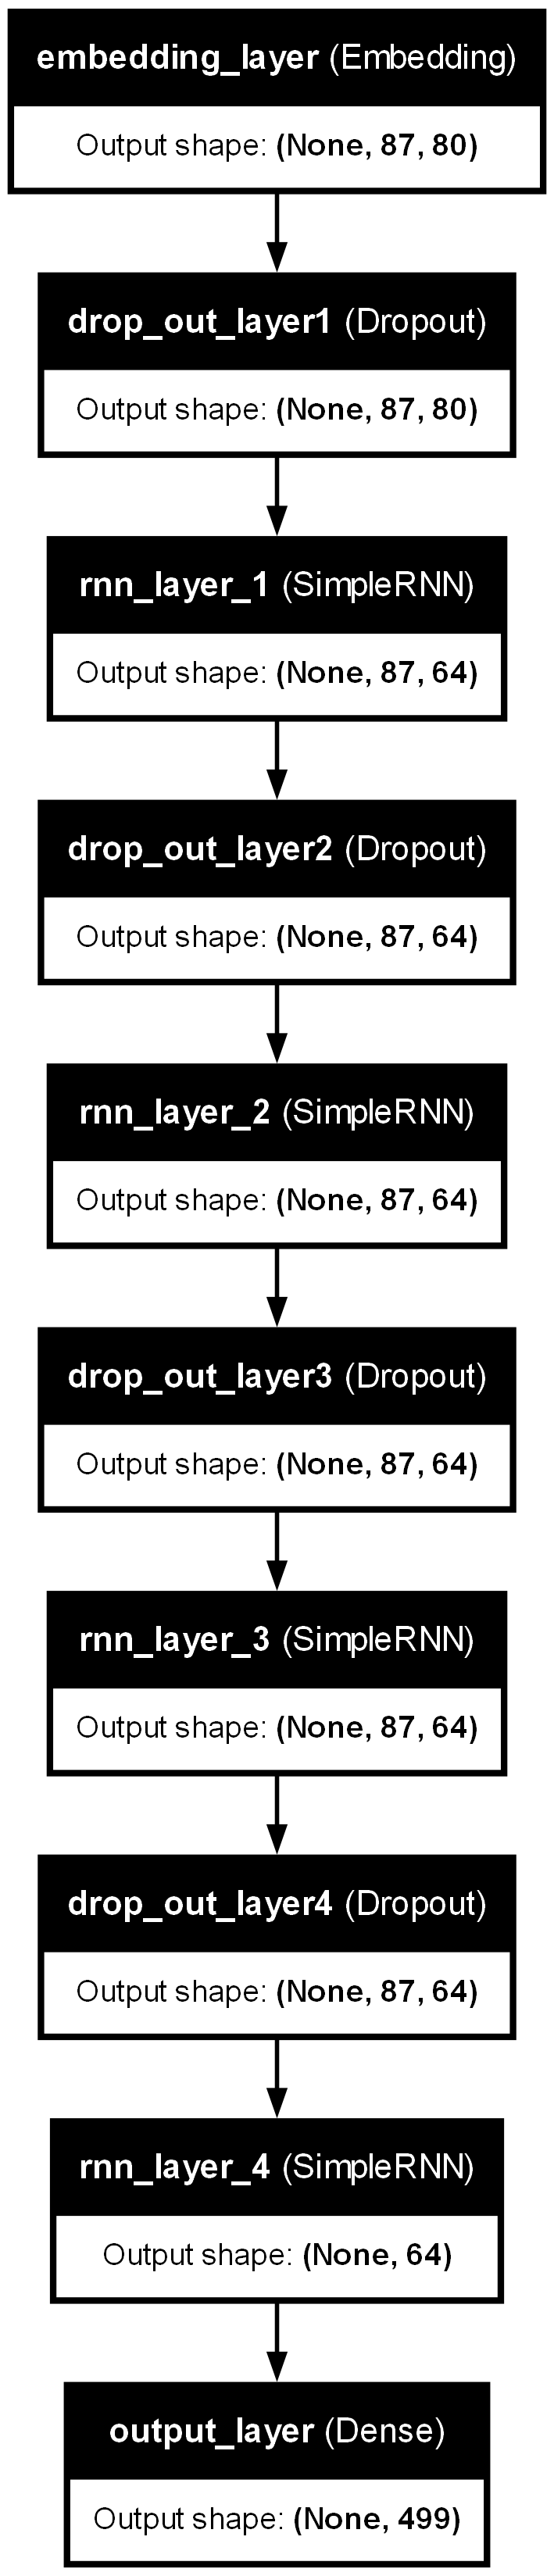

In [27]:
# Tạo đồ thị cho mô hình
plot_model(model_generate, to_file='../picture_model/model_RNN_generate_text.png', show_shapes=True, show_layer_names=True)

> Get the weight of the embedding layer

In [28]:
weights = model_generate.layers[0].get_weights()[0]
# Giảm chiều dữ liệu sử dụng t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(weights)
print(embeddings_2d[1:3])

[[ 0.40300527  1.3230014 ]
 [ 0.01216506 -3.862652  ]]


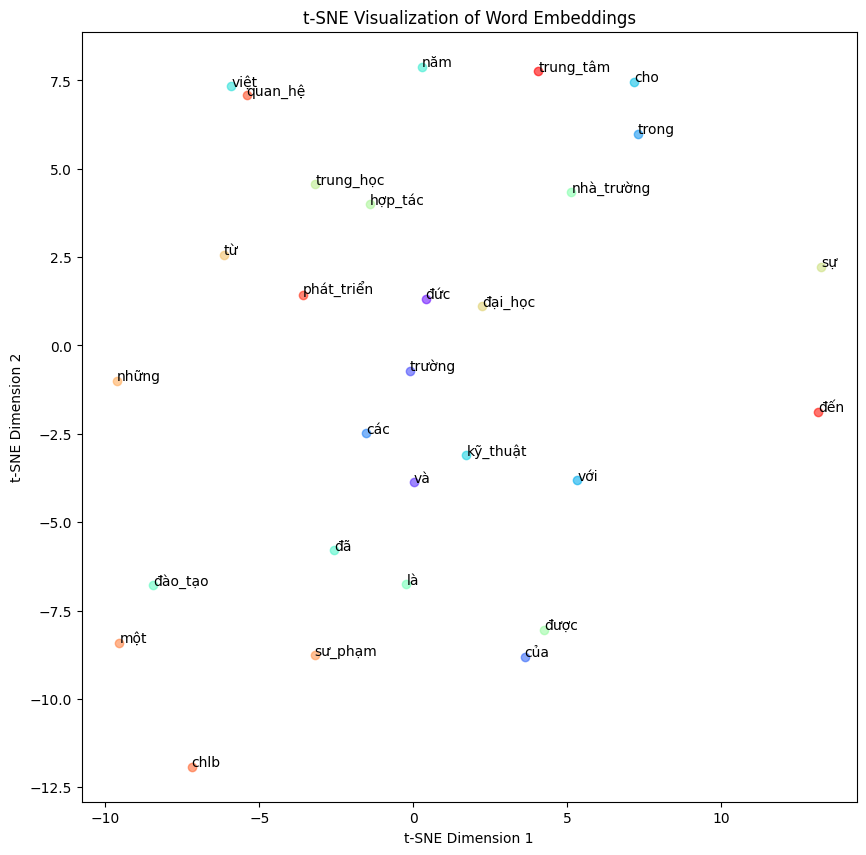

In [29]:
# Vẽ trực quan hóa với nhãn từ
# Màu cho mỗi từ
colors = plt.cm.rainbow(np.linspace(0, 1, 30))
plt.figure(figsize=(10, 10))
for i in range(1,30):  
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], marker='o', color=colors[i], alpha=0.6)
    plt.annotate(df_train_corpus.index_word[i+1], (embeddings_2d[i, 0], embeddings_2d[i, 1]))
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of Word Embeddings')
plt.show()


### 3.5 Evaluation 

> Data Preprocessing sample

In [30]:
def Preprocessing(sentence):
    sentence=ViTokenizer.tokenize(sentence)
    sentence=df_train_corpus.texts_to_sequences([sentence])
    sentence = Padding(sentence)
    return sentence

> Generate 20 word

In [31]:
next_words = 20
seed_text="Trường Đại học Sư phạm Kỹ thuật TP HCM với 53 năm xây dựng và phát triển đã đào tạo"
y_predict=[]
def Recommend(seed_text):
    for _ in range(next_words):
        token_list = Preprocessing(seed_text.lower())
        predicted_probs = model_generate.predict(token_list)
        predicted_word = df_train_corpus.index_word[np.argmax(predicted_probs)]
        seed_text += " " + predicted_word
        y_predict.append(predicted_word)
    return seed_text


> Recommend text

In [32]:
y_result=Recommend(seed_text)
print(y_result)
print(y_predict)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Trường Đại học Sư phạm Kỹ thuật TP HCM với 53 năm xây dựng và phát triển đã đào tạo cho đất_nước hơn 47500 kỹ_sư giáo_viên dạy nghề 1300 thạc sỹ sỹ đào_tạo và bồi_dưỡng nguồn nhân_lực chất_lượng cao cho
['cho', 'đất_nước', 'hơn', '47500', 

#### 3.5 Evaluating 

In [33]:
# y_true = ["came","to","Vietnam","to","find","a","reliable","partner", "to","receive"]
# accuracy = accuracy_score(y_true, y_predict)
# print(f'Accuracy: {accuracy:.4f}')

# precision = precision_score(y_true, y_predict, average='weighted')
# print(f"Precision: {precision:.4f}")

# recall = recall_score(y_true, y_predict, average='weighted')
# print(f"Recall: {recall:.4f}")

# f1score = f1_score(y_true, y_predict, average='weighted')
# print(f"F1-score: {f1score}")